### Satellite position and Speed

The number of RSOs - artificial objects that are in orbit around earth has nearly doubled during the last 2 decades, from around 11K to 20K in 2019. This number is expected to rise due to satellite technology improvements and lower costs of production. 

The **challenge** is to predict a more accurate orbit trajectory and satellite positions in order to avoid collisions and avoid the space debris. An uncontrolled chain of collisions and a huge amount of space debris cause what is called the **Kessler Syndrome**

[Kessler Syndrome](https://www.google.com/search?q=kessler+syndrome&rlz=1C5CHFA_enES1015ES1015&oq=kessler+syndrome&aqs=chrome.0.69i59j0i22i30l9.2994j0j7&sourceid=chrome&ie=UTF-8) is a phenomenon in which the amount of junk in orbit around Earth reacehs a point where it just creates more and more space Debris, causing substantial problems for satellites, astronauts and mission planners. Some of the day to day problems might include internet connections and mobile communications interruptions. In order to avoid cascade effects, we need to predict position and velocity for satellites.

### What we use ML for ?

Predicting position and satellite speed. The dataset has been reselased by the Russian Astronomical Science Centre.
The aim is to make predictions for the true **kinematic states** (satellite positions and velocity) of 600 satellites in the final 7 days of Jan 2014.

 

In [197]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import time
import sklearn
from sklearn.metrics import mean_squared_error

### Import DVCLive to add the code for experiments 
from dvclive import Live

In [198]:
def read_data(path):
    """Reads the data"""
    data = pd.read_csv(path)
    return data

### Dataset description

* The **jan_train** dataset contains data on both true and simulated kinematic states of 600 satellites for the 24-day period of time from 01-Jan-2014 00:00 to 24-Jan-2014 23:59.

* The **jan_test** dataset contains data on only the simulated kinematic states of the same 600 satellites for the final 7-day period of time from 25-Jan-2014 00:00 to 30-Jan-2014 23:59.

* The **answer_key** dataset contains data on only the true kinematic states of the same 600 satellites for the final 7-day period of time from 25-Jan-2014 00:00 to 30-Jan-2014 23:59. NOTE: The answer_key should only be used for the purpose of evaluation, NOT for training.

In [199]:
train = read_data('../dataset/jan_train.csv')
test = read_data('../dataset/jan_test.csv')
key = read_data('../dataset/answer_key.csv')

In [200]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503227 entries, 0 to 503226
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      503227 non-null  int64  
 1   epoch   503227 non-null  object 
 2   sat_id  503227 non-null  int64  
 3   x       503227 non-null  float64
 4   y       503227 non-null  float64
 5   z       503227 non-null  float64
 6   Vx      503227 non-null  float64
 7   Vy      503227 non-null  float64
 8   Vz      503227 non-null  float64
 9   x_sim   503227 non-null  float64
 10  y_sim   503227 non-null  float64
 11  z_sim   503227 non-null  float64
 12  Vx_sim  503227 non-null  float64
 13  Vy_sim  503227 non-null  float64
 14  Vz_sim  503227 non-null  float64
dtypes: float64(12), int64(2), object(1)
memory usage: 57.6+ MB


In [201]:
train.describe()

,id,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
count,5.032270e+05,503227.00000,503227.000000,503227.000000,503227.000000,503227.000000,503227.000000,503227.000000,503227.000000,503227.000000,503227.000000,503227.000000,503227.000000,503227.000000
mean,6.166217e+05,308.73285,-853.424865,402.306452,-73.143385,-0.001196,0.000692,-0.000004,-956.526943,327.145192,-83.960621,-0.001451,0.000761,-0.000410
std,3.566322e+05,171.48208,25370.592477,25618.708154,20634.331833,2.641560,2.595759,2.115538,25372.330435,25606.021391,20662.073081,2.640315,2.597858,2.113790
min,0.000000e+00,0.00000,-251938.766780,-286031.403281,-178922.412426,-8.286673,-8.231654,-8.004109,-255037.952966,-282851.387908,-180250.922287,-8.243159,-8.329723,-7.608696
25%,3.071875e+05,166.00000,-13149.249048,-11642.206414,-8008.723282,-1.899626,-1.875851,-1.254823,-13153.655148,-11704.492789,-7970.451958,-1.902258,-1.874874,-1.246798
50%,6.161820e+05,312.00000,-545.685565,514.726887,32.264258,0.014117,-0.043151,0.010085,-635.247190,535.867911,43.537419,0.020405,-0.011274,0.012062
75%,9.260245e+05,461.00000,11261.755944,12617.338414,8255.508166,1.960258,1.853402,1.239201,11174.979343,12558.738194,8219.956549,1.951909,1.862468,1.235249
max,1.233688e+06,599.00000,200382.689756,212443.393808,197200.530574,8.103981,10.444513,8.644108,200779.519772,209619.553857,198526.091552,7.431851,7.989365,8.644165


### Variable description

* **id (integer)**: unique row identifier
* **epoch (datetime)**: datetime (at the instant of measurement) in "%Y-%m-%d %H:%M:%S.%f" format (e.g. 2014-01-27 18:28:18.284)
* **sat_id (integer)**: unique satellite identifier, ranging from 0 to 599
* **x, y, z (float)**: the true position coordinates of a satellite (km)
* **Vx, Vy, Vz (float)**: the true speeds of a satellite, measured along the respective axes (km/s)
* **x_sim, y_sim, z_sim (float)**: the simulated position coordinates of a satellite (km)
* **Vx_sim, Vy_sim, Vz_sim (float)**: the simulated speeds of a satellite, measured along the respective axes (km/s)

<AxesSubplot: >

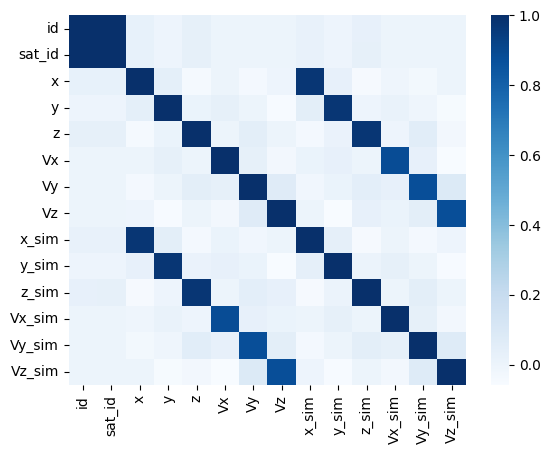

In [202]:
### Correlation matrix
corr = train.corr(numeric_only=True)
sns.heatmap(corr, cmap="Blues")

### Analysis
There seems to be a linear relationship in between **position** and **simulated position** and **velocity** and **simulated velocity**

### PairPlot 

* Only a clear **linear** relationship in x positions , but not in velocity. 

* The **individual features** do look like standard normally distributed data , therefore a Standard scaler might initially be a good choice

In [203]:
#sns.pairplot(train)

### Machine Learning Model

#### Target variables & Machine Learning Challenge

Taking into account the challenge and dataset, coming from an already known simulated trajectories (position and velocity) we want to predict real kinematic trajectories position and velocity. Therefore, we have **multiple target variables** and continuous variables. We will use a [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor). 


We use an ensemble method , in which we use multiple learning algorithms to obtain better predictive performance. For that we fit multiple target variable regression trees and average results. A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree. A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In a nutshell, we could say that this strategy consists of fitting one regressor per target and then to an average ensemble method. If in in a single target scenario we fit one tree, here we have a forest. 

![Random Forest Regressor Diagram](/docs/images/random_forest_regressor.jpeg)

#### Target variables 

* **x, y, z (float)**: the true position coordinates of a satellite (km)
* **Vx, Vy, Vz (float)**: the true speeds of a satellite, measured along the respective axes (km/s)

In [204]:
from IPython import display
display.Image(url='https://github.com/iterative/VSCode-DVC-Workshop/blob/main/docs/images/random_forest_regressor.jpeg')

### Pipeline

* Load data --> *read_data*
* Feature selection --> *feature_selection*
* Split Data --> *split_data*
* Normalization --> *standard_classifier*
* Classifier --> *ensemble RandomForest* and *multioutput regressor*
* Evaluation Metrics --> *acc* and *RMSE*

#### Feature Selection

In [205]:
def feature_selection(data, list_column_x, list_column_y):
    """Select features for training and target features"""
    X = data[list_column_x]
    Y = data[list_column_y]
    return X , Y

In [206]:
def transform_to_datetime(data, column):
    """Applies a standard classifier"""
    data[column] = pd.to_datetime(data[column], errors='coerce')    

In [207]:
def delta_time(data, column):
    """Create Delta columns for daytime"""
    data['Day'] = data[column].apply(lambda time: time.day)
    data['Hour'] = data[column].apply(lambda time: time.hour)
    data['Minute'] = data[column].apply(lambda time: time.minute)

In [208]:
transform_to_datetime(train, 'epoch')
delta_time(train, 'epoch')

In [209]:
train

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,Day,Hour,Minute
0,0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,1,0,0
1,1,2014-01-01 00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,1,0,46
2,2,2014-01-01 01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,1,1,33
3,3,2014-01-01 02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,1,2,20
4,4,2014-01-01 03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,1,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503222,1233684,2014-01-24 22:18:34.370,599,-22282.245721,2176.275085,4184.918699,1.255727,4.018148,-0.540243,-22847.208402,80.070907,4444.798405,0.870781,4.035965,-0.467196,24,22,18
503223,1233685,2014-01-24 22:43:25.007,599,-19551.683596,7997.489974,3224.501905,2.419800,3.729286,-0.746051,-20717.460440,6016.252299,3592.204365,2.003622,3.872352,-0.675867,24,22,43
503224,1233686,2014-01-24 23:08:15.645,599,-15064.616469,13079.761912,1975.820551,3.587560,3.009816,-0.920914,-16847.612994,11429.130312,2439.160526,3.186335,3.315717,-0.865266,24,23,8
503225,1233687,2014-01-24 23:33:06.283,599,-8953.211355,16721.787269,516.231786,4.556922,1.794477,-1.020603,-11273.779239,15659.892239,1041.308701,4.253614,2.276720,-0.996589,24,23,33


In [210]:
list_column_x = ['id', 'sat_id', 
                 'x_sim','y_sim', 'z_sim', 
                 'Vx_sim', 'Vy_sim', 'Vz_sim']
list_column_y = ['x', 'y', 'z', 
                 'Vx', 'Vy', 'Vz']

X, y = feature_selection(train, list_column_x, list_column_y)

In [211]:
train = transform_to_datetime(train,'epoch')

In [212]:
train

#### Split

In [213]:
def split_data(X,y, size, state):
    """splits data into training and test set"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=size, random_state=state)
    return X_train, X_test, y_train, y_test

In [214]:
X_train, X_test, y_train, y_test = split_data(X,y, 0.33, 42)

In [215]:
def standard_scaler(data):
    """Applies a standard classifier"""
    scaler = StandardScaler().fit(data)
    data_transform = scaler.transform(data)
    return data_transform

In [216]:
X_data_transformed = standard_scaler(X_train)

### Machine Learning Model . 

Some parameters included in [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) to highlight are :

* **n_estimators**: *int, default=100* . number of trees in the forest . Default = 100
* **max_samples**: *int or float, default=None* sub-sample size that we use to fit the different trees. For it to work bootstrap=True. If None, means that is going to use all the dataset for it. 
* **max_depth**: *int, default=None* . Maximum depth of the tree . If None, expansion until min_samples_split or untill all leaves are pure.
* **min_samples_split**: *int or float, default=2* The minimum number of samples required to split an internal node. More examples, more conservative
* **min_impurity_decrease**: *float, default=0.0* A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

In [217]:
def RandomForestModel(X,Y):
    """Fits the classifier"""
    regressor = RandomForestRegressor(bootstrap=True, n_estimators = 150, max_samples=2000)
    regressor.fit(X_data_transformed, y_train)
    return regressor

In [218]:
### Declare DVC Live
live = Live()

In [219]:

start = time.time()
model = RandomForestModel(X_data_transformed,y_train)
end = time.time()
total_time = end - start 
total_time 

1.9926340579986572

In [220]:
X_data_transformed_test = standard_scaler(X_test)
prediction = model.predict(X_data_transformed_test) 
mse = mean_squared_error(y_test, prediction)

In [221]:
with Live(save_dvc_exp=True) as live:
    live.log_metric("Acc train",model.score(X_data_transformed, y_train))
    live.log_metric("Mean Square error", mse)


### acc Score (Acc on train)

In [222]:
X_data_transformed_test = standard_scaler(X_test)

In [223]:
model.score(X_data_transformed_test, y_test)

0.7583913014046043

### Test Data acc (Acc on test)

In [224]:
test = test[['id', 'sat_id', 'x_sim','y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']].copy()
test_scale = StandardScaler().fit_transform(test)
model.score(test_scale, key)

0.6433502236527114

In [225]:
print('experiment finished table?')

experiment finished table?
